In [54]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as con
import astropy.units as u
from astropy.io import ascii as a
from astropy.table import Table
from scipy.optimize import root
from scipy.interpolate import Akima1DInterpolator
from scipy.integrate import solve_ivp
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Simple EOS for neutron stars

Note that for this exercise we will be using natural units where $\hbar=c=\epsilon_0=1$.

The RMF interaction Lagrangian is given by:

$\mathcal{L}_{\mathrm{int}}= \bar{\psi}\Big[g_s\phi-\big(g_vW_\mu+\frac{g_\rho}{2}\vec{\tau}\cdot \vec{b_\mu}+\frac{e}{2}(1+\tau_3)A_\mu\big)\gamma^\mu\Big]\psi-\frac{\kappa}{3!}(g_s\phi)^3-\frac{\lambda}{4!}(g_s\phi)^4$

where spinor $\psi = [\psi_p, \psi_n]$ for nucleons, $\phi$ is the scalar $\sigma$ meson, $W_\mu$ is the vector $\omega$ meson, and $\vec{b_\mu}$ is the vector-isovector $\rho$ meson. This Lagrangian also has a kinetic part however traditionally in literature you'll see just the interaction Lagrangian. This is because the kinetic terms come from QFT and Lagrange theory, therefore are not fit to properties of the nuclear interaction.

The model parameters are going to be the Yukawa couplings $g_s,\, g_v,\, \&\, g_\rho$, the masses of each meson $m_s,\, m_v,\, \&\, m_\rho$, and the nonlinear couplings $\kappa$ and $\lambda$. The nonlinear couplings $\kappa$ and $\lambda$ are cubic and quartic scalar self-couplings. These are important for softening the nuclear incompressibility $K_0$. Traditionally, there are many other couplings one could add to this Lagrangian (try this yourselves!) but for simplicity they are omitted.

In this exercise, we will be working with the NL3 interaction of ... which is a very stiff equation of state model for neutron stars but does well for finite nuclei. First, we need to define the necessary couplings.

In [53]:
#Masses all in MeV, couplings dimensionless except where noted

m = 939       # nucleon mass
ms = 508.194  # NL3 scalar mass
mv = 782.5    # omega mass
mp = 763      # rho mass

m_e = .511    #electron mass
m_m = 105.7   #muon mass

gs2 = 104.3871 #scalar yukawa
gv2 = 165.5854 #vector yukawa
gp2 = 79.6     #rho yukawa

kappa = 3.8599 #nonlinear s^3 [MeV]
lambd = -1.5905e-2 # " "  s^4

hbc = (con.hbar*con.c).to('MeV fm').value #hbar*c in MeV fm

# Solving for equations of motion

After taking the mean-field approximation, meson fields can be replaced by their expectation values. We will also combine the bare meson field their respective Yukawa coupling as $$(g_s\phi,g_v W_0,g_\rho b_0)\longrightarrow (\Phi,V_0,B_0)\,.$$

$\frac{m_s^2}{g_s^2}\Phi +\frac{\kappa}{2}\Phi^2+\frac{\lambda}{6}\Phi^3 = \rho_s^p+\rho_s^n$

$\frac{m_v^2}{g_v^2}V_0=\rho_p+\rho_n$

$\frac{m_\rho^2}{g_\rho^2}B_0=\rho_p-\rho_n$

where baryon densities are $\rho_{n,p}$ for neutrons and protons and the scalar densities are defined from Fermi-Dirac theory:

$\rho_s^i = \frac{1}{\pi^2}\int_0^{k_F^i}k^2\frac{M_i^*}{\sqrt{k^2+M_i^{*2}}}dk = \frac{M_*}{2\pi^2}\Big(k_F\sqrt{k_F^2+M_*^2}-M_*^2\rm{arcsinh}(\frac{k_F}{M_*})\Big)$.

Here, $k$ is the fermi momentum of particle $i$ and $M^*$ is the effective Dirac mass. The fermi momentum is defined as

$$k^i = (3\pi\rho^i)^{1/3}$$

and the Dirac mass is defined as $$M^* = m-\Phi$$.

First thing, we need to code up the functions which will solve for the meson fields. Since the $\omega$ and $\rho$ are point couplings, these are straightforward. To solve for the scalar field, however, we will need to use a nonlinear solver. I like using root because it is robust.

In [29]:
def get_kF(dens): 
    """
    Returns the fermi momentum in units of dens^1/3
    """
    return (3*np.pi**2*dens)**(1/3)

def sca_dens(kF, S):
    """
    Returns scalar density provided kF and scalar field in MeV. 
    Outputs density in MeV^3
    """
    mdirac = m - S
    return mdirac*(kF*np.sqrt(kF**2+mdirac**2)-mdirac**2*np.arcsinh(kF/mdirac))/2./np.pi**2

def solve_mesons(dens, Yp): #solve for the meson fields
    """
    Function to solve for the meson field equations provided the baryon density in MeV^3 and the proton fraction.
    Outputs: 3D array with (S, V, B) in MeV units.
    """
    kFp = get_kF(dens*Yp)
    kFn = get_kF(dens*(1-Yp))
    V = dens*gv2/mv**2
    B = (2*Yp-1)*dens*gp2/mp**2
    S_out = root(lambda x: x - gs2/ms**2*(sca_dens(kFp, x)+sca_dens(kFn, x)-kappa/2*x**2-lambd/6*x**3),200,method='lm').x[0]

    return [S_out,V,B]

# Computing pressure and energy density

Now we use these meson fields to calculate the energy density and pressure at a given density.

$\epsilon(\rho) = \frac{1}{2}\frac{m_s^2}{g_s^2}\Phi^2-\frac{1}{2}\frac{m_v^2}{g_v^2}V_0^2-\frac{1}{2}\frac{m_\rho^2}{g_\rho^2}B_0^2+\frac{\kappa}{3!}\Phi^3+\frac{\lambda}{4!}\Phi^4
+\rho V_0+\frac{1}{2}(\rho_p-\rho_n)B_0+\sum_{i=p,n,e,\mu}\frac{1}{\pi^2}\int_0^{k_i}dkk^2\sqrt{k^2+M^{*2}_i}$
    
$p(\rho) = -\frac{1}{2}\frac{m_s^2}{g_s^2}\Phi^2+\frac{1}{2}\frac{m_v^2}{g_v^2}V_0^2+\frac{1}{2}\frac{m_\rho^2}{g_\rho^2}B_0^2
-\frac{\kappa}{3!}\Phi^3-\frac{\lambda}{4!}\Phi^4+\sum_{i=p,n,e,\mu}\frac{1}{3\pi^2}\int_0^{k_F^i}dk \frac{k^4}{\sqrt{k^2+M_i^{*2}}}
$

In [30]:
#energy density fermi gas
def en_int(kF,m_eff):
    return 1/8/np.pi**2*(kF*np.sqrt(kF**2+m_eff**2)*(2*kF**2+m_eff**2)-m_eff**4*np.arcsinh(kF/m_eff))

#pressure fermi gas
def pre_int(kF,m_eff):
    return 1/24/np.pi**2*(kF*(2*kF**2-3*m_eff**2)*np.sqrt(kF**2+m_eff**2)+3*m_eff**4*np.arcsinh(kF/m_eff))

def e_NS(dens,Yp,kFe,s_field,v_field,p_field):
    """
    Calculate the energy density of neutron star matter provided meson fields, proton fraction, density, and electron fermi energy.
    Returns energy density in MeV^4.
    """
    m_eff = m-s_field
    kF_n = get_kF((1-Yp)*dens)
    kF_p = get_kF(Yp*dens)
    kF_e = kFe
    kF_m = (kF_p**3-kF_e**3)**(1/3)
    
    #scalar-field terms
    s_terms = 1/6*kappa*(s_field)**3+1/24*lambd*(s_field)**4+1/2*ms**2/gs2*(s_field)**2
    #vector field energy terms
    v_terms = v_field*dens-1/2*mv**2/gv2*(v_field)**2
    #rho field energy terms
    r_terms = -1/2*mp**2/gp2*(p_field)**2+1/2*p_field*(2*Yp-1)*dens
    #particle energy terms
    neu_energy = en_int(kF_n,m_eff)
    pro_energy = en_int(kF_p,m_eff)
    ele_energy = en_int(kF_e,m_e)
    mu_energy = en_int(kF_m,m_m)
    
    return s_terms + r_terms + neu_energy + pro_energy + v_terms + ele_energy + mu_energy

def p_NS(dens,Yp,kFe,s_field,v_field,p_field):
    """
    Calculate the pressure of neutron star matter provided meson fields, proton fraction, density, and electron fermi energy.
    Returns pressure in MeV^4.
    """
    m_eff = m-s_field
    kF_n = get_kF((1-Yp)*dens)
    kF_p = get_kF(Yp*dens)
    kF_e = kFe
    kF_m = (kF_p**3-kF_e**3)**(1/3)

    #scalar self-interaction terms
    s_terms = -1/6*kappa*(s_field)**3-1/24*lambd*(s_field)**4-1/2*ms**2/gs2*(s_field)**2
    #vector field energy terms
    v_terms = 1/2*mv**2/gv2*(v_field)**2
    #rho field energy terms
    r_terms = 1/2*mp**2/gp2*(p_field)**2
    #particle energy terms
    neu_energy = pre_int(kF_n,m_eff)
    pro_energy = pre_int(kF_p,m_eff)
    ele_energy = pre_int(kF_e,m_e)
    mu_energy = pre_int(kF_m,m_m)
    
    return r_terms + s_terms + neu_energy + pro_energy + v_terms + ele_energy + mu_energy

# Beta Equilibrium

In order for neutron stars to be stable, they have to be in beta equilibrium. The balancing between neutrons, protons, and neutrons is $$n\leftrightarrow p+e$$
which requires that the chemical potentials equal each other.

$$\mu_n=\mu_p+\mu_e$$

where the chemical potentials defined from $\mu = \frac{\partial \epsilon}{\partial n}$:

$\mu_{p,n} = \sqrt{k_F^2+M_*^2}+V_0\pm \frac{1}{2}B_0$

$\mu_e = \sqrt{k_F^2+M_e^2}$

In addition to this, charge equilibrium states that the proton and lepton densities be equal. So there is an additional constraint that we need to solve for.

$\rho_p=\rho_e+\rho_\mu$, where the chemical potential of muons equals that of electrons.

With all of these you can solve for the beta-equilibrized neutron star equation of state.

In [31]:
def muon_equil(kp):
    """
    Solves for the muon fermi momentum. Returns the fermi momentum of electrons.
    """
    min_func = lambda ke: ke**3+(ke**2+m_e**2-m_m**2)**1.5-kp**3
    sol = root(min_func,kp)
    return sol.x[0]

def beta_equil(Yp,dens,fields):
    """
    Uses beta equilibrium condition to determine proton fraction and electron fermi momentum.
    Returns difference in chemical potentials between neutrons and charged particles. n -> p + e
    """
    s_field,v_field,p_field = fields
    m_eff = m-s_field
    kF_n = get_kF((1-Yp)*dens)
    kF_p = get_kF(Yp*dens)
    kF_e = np.piecewise(kF_p,[kF_p<=np.sqrt(m_m**2-m_e**2),kF_p>np.sqrt(m_m**2-m_e**2)],[kF_p,muon_equil(kF_p)])
    return np.sqrt(kF_n**2+m_eff**2)-(np.sqrt(kF_p**2+m_eff**2)+np.sqrt(kF_e**2+m_e**2)+p_field),kF_e

def get_Yp(dens,Y0=0):
    """
    Returns proton fraction and electron fermi momentum to achieve beta equilibrium.
    """
    min_func = lambda Y: beta_equil(Y,dens,solve_mesons(dens,Y))[0]    
    Y = root(min_func,Y0).x
    return Y[0],beta_equil(Y[0],dens,solve_mesons(dens,Y[0]))[1]

# Putting it all together

In a more detailed analysis, one would have to determine the transition density from the nonuniform crust to the uniform liquid core. Here I've gone through the liberty of providing that density for you. :)

In [41]:
rho_C = 0.052 #core-crust transition density in fm^-3

E,P = [],[]
dens = np.logspace(np.log10(rho_C),np.log10(3),100)*hbc**3 #density array defined in logspace
N = dens/hbc**3; fields = np.zeros(3)
Yp = 0
def do_this(dens):
    Yp,kFe = get_Yp(dens)
    fields = solve_mesons(dens,Yp)
    E = e_NS(dens,Yp,kFe,*fields)
    P = p_NS(dens,Yp,kFe,*fields)
    return E,P

output = np.array(list(map(do_this,dens)))

E = np.array(output[:,0])/hbc**3
P = np.array(output[:,1])/hbc**3

/var/folders/8v/46flqrqx7073m275wdfbyr3w0018yf/T/ipykernel_27840/733526434.py:5: RuntimeWarning: invalid value encountered in power
  min_func = lambda ke: ke**3+(ke**2+m_e**2-m_m**2)**1.5-kp**3


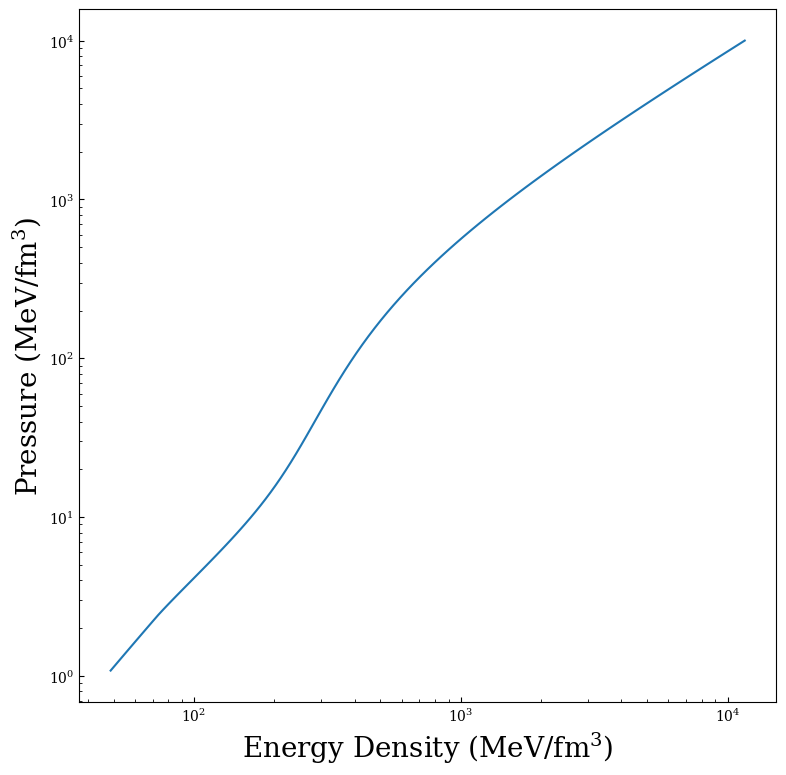

In [45]:
#Here we'll plot the equation of state.

plt.figure(1,(9,9))
plt.plot(E,P)
plt.xlabel('Energy Density (MeV/fm$^3$)',fontsize=20)
plt.ylabel('Pressure (MeV/fm$^3$)',fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(which='both',direction='in')
plt.show()

# Adding a neutron star crust

Now we need to add the crust. In a real self-consistent calculation, you'd need to tabulate the stable nuclei from the neutron-drip density and increase the density until you reach the core-crust transition density. Here I'll provide a simple approximation which does well for the systems we'll be using and the observables we're interested in.

In [91]:
def stitch_crust(e_core,p_core,n_core):
    n_drip = 2.6e-4 #neutron drip line for outer crust in 1/fm^3
    crust_dat = np.loadtxt('OCDZ.txt')
    n_out = crust_dat[:,2]
    n_out = n_out[n_out<=n_drip]
    p_out = crust_dat[:,0][:len(n_out)]
    e_out = crust_dat[:,1][:len(n_out)]
    
    try:
        cs2_core = Akima1DInterpolator(e_core,p_core).derivative()(e_core[0])
    except:
        raise Exception("EOS has failed")
    cs2_out = Akima1DInterpolator(e_out,p_out).derivative()(e_out[-1])
    LHS = np.array([[1,e_core[0],e_core[0]**2,e_core[0]**3],
                    [1,e_out[-1],e_out[-1]**2,e_out[-1]**3],
                    [0,1,2*e_core[0],3*e_core[0]**2],
                    [0,1,2*e_out[-1],3*e_out[-1]**2]])
    RHS = np.array([p_core[0],p_out[-1],cs2_core,cs2_out])
    sol = np.linalg.solve(LHS,RHS)
    eos = np.polynomial.Polynomial(sol)
    
    e_inn = np.logspace(np.log10(e_out[-1]),np.log10(e_core[0]),25)[:-1]
    p_inn = eos(e_inn)
    
    p_all = np.concatenate((np.concatenate((p_out,p_inn)),p_core))
    e_all = np.concatenate((np.concatenate((e_out,e_inn)),e_core))

    #There's sometimes a machine error in there so this removes it
    e_all = np.delete(e_all,np.where(np.diff(p_all)<0))
    p_all = np.delete(p_all,np.where(np.diff(p_all)<0))
    
    return e_all,p_all

In [92]:
E_all,P_all = stitch_crust(E,P,N)

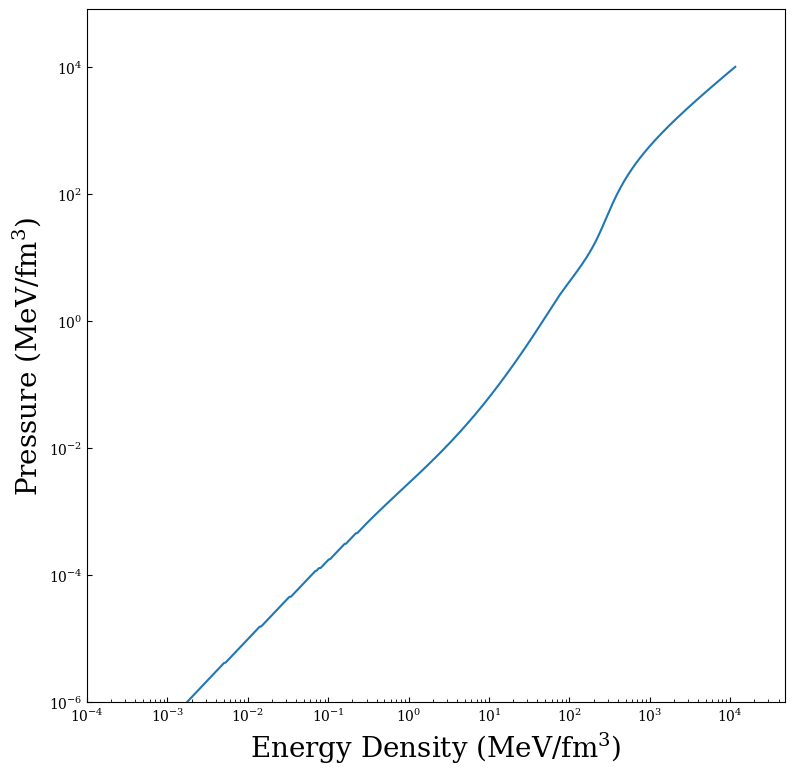

In [51]:
plt.figure(1,(9,9))
plt.plot(E_all,P_all)
plt.xlabel('Energy Density (MeV/fm$^3$)',fontsize=20)
plt.ylabel('Pressure (MeV/fm$^3$)',fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4,)
plt.ylim(1e-6,)
plt.tick_params(which='both',direction='in')
plt.show()

In [124]:
TOV(0.01,[100*MeV_to_Msun,0.0])

31747492.17892761 8057311.689 0.0


ZeroDivisionError: float division by zero

In [140]:
c = 299792.458 #km/s
G = 1.327E11     # km^3/s^2/Msun
MeV_to_Msun = 80573.11689 #  MeV/fm^3 to Msun/km/s^2

eos_intp = Akima1DInterpolator(P_all*MeV_to_Msun,E_all*MeV_to_Msun)
def stop_condition(r,y0):
    return y0[0] - P_all[0]*MeV_to_Msun

stop_condition.terminal = True
stop_condition.direction = -1  # Only trigger when crossing from above

def TOV(r,y0):
    p,M = y0
    eps = eos_intp(p)

    if(r==0):
        return np.r_[0,0]

    if M!=0.0:
        T1 = -G*M*eps/c**2/r**2
        T2 = 1+p/eps
        T3 = 1+4*np.pi*r**3*p/M/c**2
        T4 = 1-2*G*M/c**2/r
    else:
        T1=0
        T2=T3=T4 = 1
    
    dmdr = 4*np.pi*r**2*eps/c**2
    dpdr = T1*T2*T3/T4
    return np.r_[dpdr,dmdr]

In [138]:
sol = solve_ivp(TOV,[0.0,50],np.r_[100*MeV_to_Msun,0.0],events=stop_condition)
M = sol.y[-1]
R = sol.t

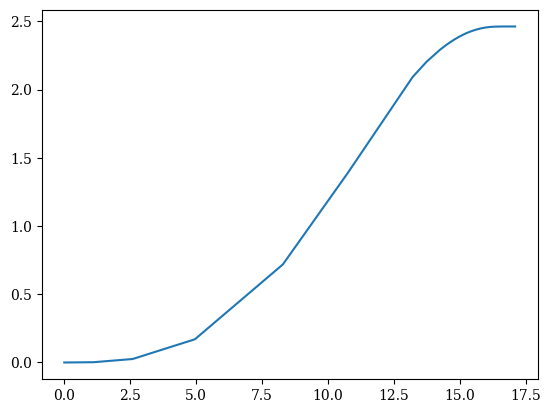

In [139]:
plt.plot(R,M)